# Simulating stacks vs non-stacks

This is a notebook to test how stacking of galaxy clusters and hierarchical models work in triaxial clusters.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(linewidth=400)

In [3]:
import xlensing
from astropy.table import Table

Lookup table loaded!


In [4]:
mass = 1e14 # mass in Msun/h
concentration = 4.
nfw_z_halo = 0.3
RA = 0
DEC = 0


## Testing basic functions

In [5]:
xlensing.sims.rhoM(z=nfw_z_halo)

113160009026.94252

In [6]:
xlensing.sims.r_vir(nfw_z_halo, mass)

1.0179570954383916

In [7]:
xlensing.sims.critical_density(0.3,1.0)

array(4.04864605e+15)

In [8]:
xlensing.sims.NFW_tangential_shear(1e14, 4, 0.3, 1.0, .15)

array(0.02697304)

In [9]:
xlensing.sims.NFW_wcs_cluster_shear(1e14,4,0.3,1.0,0,0,0.000,-0.0003)

(0.024270067331205302-5.944452054450264e-18j)

In [10]:
gamma = xlensing.sims.NFW_wcs_cluster_shear(1e14,4,0.3,1.0,0,0,0.000,0.001)

xlensing.sims.add_shears(0.3+.0j,gamma)

(0.309372474969615+0j)

In [11]:
simplecat = xlensing.sims.make_simple_random_cat(10, width_rad=4./xlensing.cosmo.DA(0,0.3), zrange=[0.2,0.1], shape_noise=0.3)
simplecat = Table(simplecat.T,names=['ra','dec','z','e1','e2','R11','R12','R21','R22','w'])

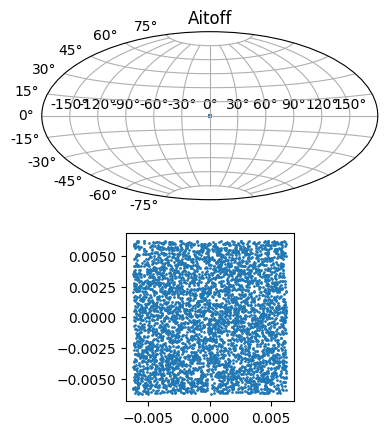

In [12]:
subplot(211, projection="aitoff")
scatter(simplecat['ra'],simplecat['dec'],s=1)
title("Aitoff")
grid(True)
subplot(212)
scatter(simplecat['ra'],simplecat['dec'],s=1)
ax = plt.gca()
ax.set_aspect('equal')

## 1 - Generate background galaxy catalogue

Generate healpix mask

In [19]:
import healpy as hp

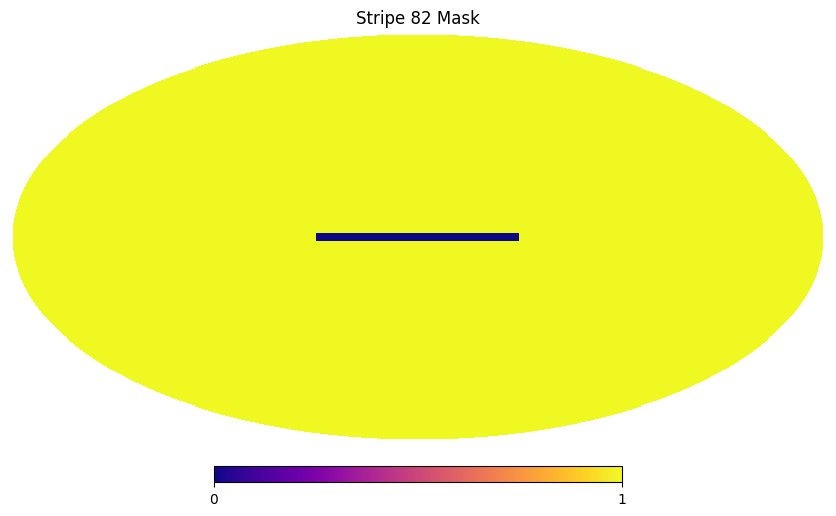

In [20]:
nside = 512
def mask_map_val(_nside,_ipix):
    """Mask loops and latitude"""
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 1
    #STRIPE
    if ((l<45)or(l>315)) and (abs(b)<1.5):
      cue = 0

    return cue

mask_map = np.zeros(hp.nside2npix(nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(nside, i)

# Presents the generated mask map
hp.mollview(mask_map, cmap='plasma',title="Stripe 82 Mask")

Using GLASS to get the galaxies.

In [21]:
# these are the GLASS imports: cosmology and everything in the glass namespace
from cosmology import Cosmology
import glass.all
import glass

# also needs camb itself to get the parameter object
import camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = 512
lmax = nside

# set up the random number generator
rng = np.random.default_rng(seed=42)

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# use CAMB cosmology
cosmo = Cosmology.from_camb(pars)

# redshift grid that will be used for a number of continuous functions
z = np.linspace(0, 3, 1000)

In [22]:
# use matter shells with 200 Mpc thickness in comoving distance
shells = glass.matter.distance_shells(cosmo, 0., 3., dx=200.)

# use a matter weight function that is uniform in redshift
mweights = glass.matter.redshift_weights(shells, zlin=0.1)

# compute the angular matter power spectra
cels = glass.camb.matter_cls(pars, lmax, mweights)

In [23]:
# compute the midpoint lensing weights
lweights = glass.lensing.midpoint_weights(shells, mweights, cosmo)

In [24]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 0.06

# true redshift distribution following a Smail distribution
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_arcmin2

# compute the galaxy number density in each shell
ngal = glass.galaxies.densities_from_dndz(z, dndz, shells)

# compute bin edges with equal density
nbins = 10
zedges = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# split distribution by tomographic bin, assuming photometric redshift errors
tomo_nz = glass.observations.tomo_nz_gausserr(z, dndz, sigma_z0, zedges)

# constant bias parameter for all shells
b = 1.2

# sigma_ellipticity as expected for a Stage-IV survey
sigma_e = 0.27

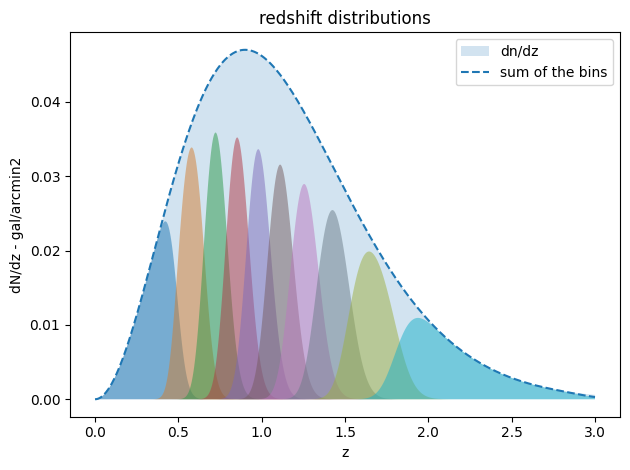

In [25]:
plt.figure()
plt.title('redshift distributions')
sum_nz = np.zeros_like(tomo_nz[0])
for nz in tomo_nz:
    plt.fill_between(z, nz, alpha=0.5)
    sum_nz = sum_nz + nz
plt.fill_between(z, dndz, alpha=0.2, label='dn/dz')
plt.plot(z, sum_nz, ls='--', label='sum of the bins')
plt.ylabel('dN/dz - gal/arcmin2')
plt.xlabel('z')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
vis = glass.observations.vmap_galactic_ecliptic(nside) #here instead of the Euclid footprint, we use the Stripe 82 footprint

In [30]:
from astropy.table import Table
# generators for clustering and lensing
generators = [
    glass.matter.gen_lognormal_matter(cels, nside, ncorr=2, rng=rng),
    glass.lensing.gen_convergence(lweights),
    glass.lensing.gen_shear(),
    glass.observations.gen_constant_visibility(vis),
    glass.galaxies.gen_positions_from_matter(ngal, b, rng=rng),
    glass.galaxies.gen_redshifts_from_nz(z, tomo_nz, shells, rng=rng),
    glass.galaxies.gen_ellip_intnorm(sigma_e, rng=rng),
    glass.galaxies.gen_shear_interp(cosmo),
]

# values we want from the simulation
yields = [
    glass.galaxies.GAL_LON,
    glass.galaxies.GAL_LAT,
    glass.galaxies.GAL_Z,
    glass.galaxies.GAL_SHE,
    glass.galaxies.GAL_POP,
]

# we will store the catalogue as a dictionary

# iterate and store the quantities of interest for our mock catalogue
i = 0
galaxy_count = 0
import gc
gc.collect()
for gal_lon, gal_lat, gal_z, gal_she, gal_pop in glass.core.generate(generators, yields):
    i += 1
    galaxy_count += len(gal_z)
    print(len(gal_z))
    catalogue = {'RA': np.array([]), 'DEC': np.array([]), 'TRUE_Z': np.array([]),
                 'G1': np.array([]), 'G2': np.array([]), 'TOMO_ID': np.array([])}
    # let's assume here that lon lat here are RA and DEC:
    catalogue['RA'] = np.append(catalogue['RA'], gal_lon)
    catalogue['DEC'] = np.append(catalogue['DEC'], gal_lat)
    catalogue['TRUE_Z'] = np.append(catalogue['TRUE_Z'], gal_z)
    catalogue['G1'] = np.append(catalogue['G1'], gal_she.real)
    catalogue['G2'] = np.append(catalogue['G2'], gal_she.imag)
    catalogue['TOMO_ID'] = np.append(catalogue['TOMO_ID'], gal_pop)
    #np.save(f"glasscast/cat{i}.npy",np.array([gal_lon, gal_lat, gal_z, gal_she, gal_pop]))
    cat = Table(catalogue)
    l = cat['RA']
    b = cat['DEC']
    cat=cat[((l<45)|(l>315)) & (abs(b)<1.5)]
    cat.write(f"partialcat{i}.fits",overwrite=True)
    del catalogue, cat
    gc.collect()

print(f'Total Number of galaxies sampled: {galaxy_count:,}')

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (543,)  and requested shape (32,)

In [26]:
pwd

'/home/LSC/vitorelli/github/xlensing/notebooks'